In [1]:
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation, Reshape, Input, Embedding, LSTM, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model, load_model
from keras.utils  import to_categorical
from datetime     import datetime
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

Using TensorFlow backend.


In [2]:
data_dir = 'numpy_arrays'
X  = 'train_picture_features.npy'
y  = 'train_picture_labels.npy'

train_features = np.load(os.path.join(data_dir, X))
train_labels   = np.load(os.path.join(data_dir, y))

print("Features:",train_features.shape)
print("Labels", train_labels.shape)

Features: (33402,)
Labels (33402,)


In [3]:
# Preprocessing features
from skimage.transform import resize

%matplotlib inline

def resize_images(arrays, side_length):
    
    array_count = arrays.shape[0]
    template    = np.zeros((side_length, side_length,3))
    all_arrays = []
    
    for array in arrays:
        
        #print(array.shape)
        height, width = array.shape[0], array.shape[1]
        if height > width:
            new_height = side_length
            diff       = side_length / height
            new_width  = width * diff
        else:
            new_width  = side_length
            diff       = side_length / width
            new_height = height * diff
            
            tmp            = resize(array, (int(new_height), int(new_width), 3), mode='constant')
            top_padding    = np.zeros((int((side_length - tmp.shape[0]) / 2), side_length, 3))
            bottom_padding = np.zeros((int(side_length - top_padding.shape[0] - tmp.shape[0]) , side_length, 3))
 
            #print(top_padding.shape)
            #print(tmp.shape)
            #print(bottom_padding.shape)
            final = np.concatenate((top_padding, tmp, bottom_padding))
            #print(final.shape)
        
        all_arrays.append(final)
    
    return np.array(all_arrays)

def crop(arrays):
    ratio_max  = 0.0
    ratio_min  = np.inf
    all_arrays = []
    
    for i, array in enumerate(arrays):
        #print("OLD: ", array.shape)
        height, width = array.shape[0], array.shape[1]
        if height > width:
            #cut height
            center = int(height / 2)
            half_width = int(width / 2)
            new = array[center-half_width:center+half_width,:]
        else:
            #cut width
            center = int(width / 2)
            half_height = int(height / 2)
            new = array[:, center-half_height:center+half_height]
            
        all_arrays.append(new)
        #print("NEW: ", new.shape)
    
    return np.array(all_arrays)

#################################

def resize_32x32(features):
    return np.array([resize(f, (32, 32, 3), mode='constant') for f in features])

def resize_32x32_grey(features):
    return np.array([resize(f, (32, 32, 1), mode='constant') for f in features])

def resize_64x64(features):
    return np.array([resize(f, (64, 64, 3), mode='constant') for f in features])


In [4]:
def preprocess(arrays):
    cropped_images = crop(arrays)
    resized_images = resize_32x32(cropped_images)
    return resized_images

processed_imgs = preprocess(train_features)
print(processed_imgs.shape)

(33402, 32, 32, 3)


(32, 32, 3)
[7.0, 4.0, 4.0]


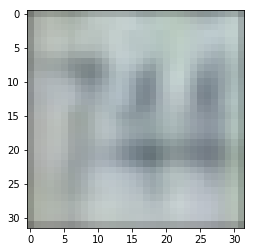

In [5]:
sample = 7
img   = processed_imgs[sample]
label = train_labels[sample]
print(img.shape)
print(label)
fig,ax  = plt.subplots(1)
ax.imshow(img)

plt.show()

In [6]:
# Preprocessing targets

def list_to_arrays(labels):
    return np.array([np.array(label) for label in labels])

def remove_val(labels, in_val, out_val):
    for label in labels:
        label[label == in_val] = out_val
    
    return labels
    #return np.where(labels==in_val, out_val, labels) 

def pad_labels(train_labels):
    print(train_labels.shape)
    #max_len = 0
    max_len = 6
    
    for arr in train_labels:
        max_len = max(len(arr), max_len)

    print("MAX LENGTH: {}".format(max_len))
    
    return np.array([((max_len - len(arr)) * [10.0]) + arr for arr in train_labels])
    #return np.array([arr + ((max_len - len(arr)) * [10.0]) for arr in train_labels])     

def one_hot_encoding(labels):
    return np.array([ to_categorical(label, num_classes=11) for label in labels])

def remove_10s(labels):
    for label in labels:
        for i, digit in enumerate(label):
            if digit > 9:
                label[i] = 0.
                
    return labels

train_labels = remove_10s(train_labels)
print(train_labels[24])
print(train_labels.shape)

padded_labels = pad_labels(train_labels)
print(padded_labels[24])
print(padded_labels.shape)

encoded_labels = one_hot_encoding(padded_labels)
print(encoded_labels[24])
print(encoded_labels.shape)

[6.0, 0.0, 1.0]
(33402,)
(33402,)
MAX LENGTH: 6
[ 10.  10.  10.   6.   0.   1.]
(33402, 6)
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
(33402, 6, 11)


In [7]:
def preprocess_labels(labels):
    labels = remove_10s(labels)
    

In [8]:
features = processed_imgs
#features = resized_images
targets = [encoded_labels[:, i] for i in range(6)]
#targets = encoded_labels
#targets = padded_labels


print("INPUT SHAPE: {}".format(features.shape))

inputs_ = Input(shape=(32,32,3))
x = inputs_

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.25)(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.25)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.25)(x)
#x = Conv2D(160, (3, 3), activation='relu', padding='same')(x)
#x = Dropout(0.25)(x)
#x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
#x = Dropout(0.25)(x)
#x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
#x = Dropout(0.25)(x)
#x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
#x = Dropout(0.25)(x)
#x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
#x = Dropout(0.25)(x)

"""
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x) 
x = Dropout(0.25)(x)
"""

"""
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x) 
x = Dropout(0.25)(x)

x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x) 
x = Dropout(0.25)(x)

x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x) 
x = Dropout(0.25)(x)
"""
###########################################
x = GlobalAveragePooling2D()(x)

#x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)

digit1 = Dense(11, activation='softmax')(x)
digit2 = Dense(11, activation='softmax')(x)
digit3 = Dense(11, activation='softmax')(x)
digit4 = Dense(11, activation='softmax')(x)
digit5 = Dense(11, activation='softmax')(x)
digit6 = Dense(11, activation='softmax')(x)

model = Model(input=inputs_, outputs=[digit1, digit2, digit3, digit4, digit5, digit6])
model.summary()

INPUT SHAPE: (33402, 32, 32, 3)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 32, 64)    1792                                         
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32, 32, 64)    0                                            
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 32, 32, 96)    55392                                        
___________________________________________________________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:67: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


In [9]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint

epochs     = 10
time_now   = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = os.path.join('models', 'model_multi_ModelAPI_' + str(epochs) + 'epochs_' + time_now +'.hdf5')

print("MODEL FILE: {}".format(model_path))

checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, save_best_only=False, monitor='acc',)

model.fit(features, targets,
          validation_split=0.25,
          epochs=epochs, 
          batch_size=32, 
          callbacks=[checkpointer], 
          verbose=1)


MODEL FILE: models/model_multi_ModelAPI_10epochs_20190708_185338.hdf5
Train on 25051 samples, validate on 8351 samples
Epoch 1/10
25051/25051 [==============================] - 940s - loss: 6.0754 - dense_3_loss: 0.0064 - dense_4_loss: 0.0110 - dense_5_loss: 0.2427 - dense_6_loss: 1.1818 - dense_7_loss: 2.3150 - dense_8_loss: 2.3186 - dense_3_acc: 0.9987 - dense_4_acc: 0.9984 - dense_5_acc: 0.9560 - dense_6_acc: 0.6953 - dense_7_acc: 0.1552 - dense_8_acc: 0.1083 - val_loss: 5.9605 - val_dense_3_loss: 0.0019 - val_dense_4_loss: 0.0052 - val_dense_5_loss: 0.2317 - val_dense_6_loss: 1.1259 - val_dense_7_loss: 2.2889 - val_dense_8_loss: 2.3070 - val_dense_3_acc: 0.9999 - val_dense_4_acc: 0.9996 - val_dense_5_acc: 0.9553 - val_dense_6_acc: 0.6974 - val_dense_7_acc: 0.1686 - val_dense_8_acc: 0.1067
Epoch 2/10
25051/25051 [==============================] - 941s - loss: 5.8513 - dense_3_loss: 1.3988e-06 - dense_4_loss: 0.0042 - dense_5_loss: 0.2228 - dense_6_loss: 1.1011 - dense_7_loss: 2.2299

25051/25051 [==============================] - 935s - loss: 5.0434 - dense_3_loss: 6.8042e-07 - dense_4_loss: 0.0043 - dense_5_loss: 0.1842 - dense_6_loss: 0.9024 - dense_7_loss: 1.8879 - dense_8_loss: 2.0647 - dense_3_acc: 1.0000 - dense_4_acc: 0.9997 - dense_5_acc: 0.9574 - dense_6_acc: 0.7234 - dense_7_acc: 0.3463 - dense_8_acc: 0.2447 - val_loss: 5.0772 - val_dense_3_loss: 0.0019 - val_dense_4_loss: 0.0058 - val_dense_5_loss: 0.1909 - val_dense_6_loss: 0.9249 - val_dense_7_loss: 1.9014 - val_dense_8_loss: 2.0523 - val_dense_3_acc: 0.9999 - val_dense_4_acc: 0.9996 - val_dense_5_acc: 0.9553 - val_dense_6_acc: 0.7114 - val_dense_7_acc: 0.3412 - val_dense_8_acc: 0.2469
Epoch 9/10
25051/25051 [==============================] - 934s - loss: 4.9445 - dense_3_loss: 4.5921e-07 - dense_4_loss: 0.0042 - dense_5_loss: 0.1789 - dense_6_loss: 0.8855 - dense_7_loss: 1.8476 - dense_8_loss: 2.0283 - dense_3_acc: 1.0000 - dense_4_acc: 0.9997 - dense_5_acc: 0.9574 - dense_6_acc: 0.7288 - dense_7_acc:

PREDICTION0: [ 10.  10.  10.  10.   1.   0.]
PREDICTION1: [ 10.  10.  10.  10.   2.   2.]
PREDICTION2: [ 10.  10.  10.  10.   3.   2.]
PREDICTION3: [ 10.  10.  10.  10.   3.   5.]
PREDICTION4: [ 10.  10.  10.  10.   1.   1.]
LABEL0: [ 10.  10.  10.  10.   1.   9.]
LABEL1: [ 10.  10.  10.  10.   2.   3.]
LABEL2: [ 10.  10.  10.  10.   2.   5.]
LABEL3: [ 10.  10.  10.  10.   9.   3.]
LABEL4: [ 10.  10.  10.  10.   3.   1.]


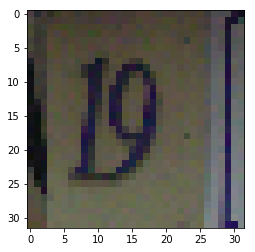

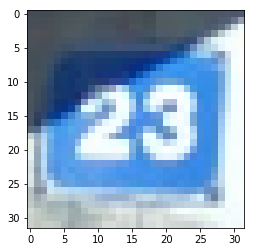

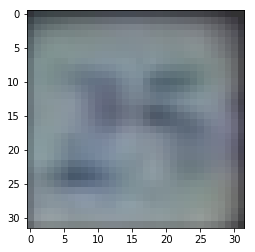

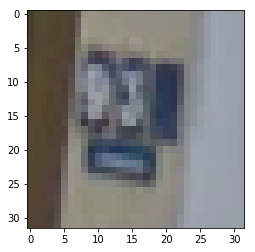

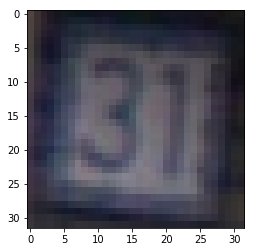

In [10]:
# TESTING

def predict(model, array):
    y_pred = model.predict(array)
    y_pred = np.array(y_pred)

    entries = [y_pred[:, i, :] for i in range(y_pred.shape[1])]
    
    all_digits = []
    for entry in entries:
        
        entry_digits = []
        for digit in entry:
            entry_digits.append(np.argmax(digit))

        all_digits.append(entry_digits)
   
    return np.array(all_digits).astype('float64')
    
test_set    = processed_imgs[:5]
predictions = predict(model, test_set)

for i, prediction in enumerate(predictions):
    print("PREDICTION{}: {}".format(i, prediction))

for i, num in enumerate(test_set):
    print("LABEL{}: {}".format(i, padded_labels[i]))

for img in test_set:
    fig,ax  = plt.subplots(1)
    ax.imshow(img)

In [11]:
def get_multidigit_accuracy(preditions, labels):
    correct = 0
    for pred, label in zip(predictions, labels):
        #print(pred, label)
        if np.array_equal(pred, label):
            correct += 1
    
    return (correct*1.0) / len(predictions)

def get_accuracy(predictions, labels):
    correct = 0
    for pred, label in zip(predictions, labels):
        print(pred, label)
        #pred_str  = "".join([str(int(p)) for p in pred if p != 10])
        #label_str = "".join([str(int(j)) for j in label])
        #print(pred_str, label_str)
        if pred_str == label_str:
            correct += 1
            
    #for i, pred in enumerate(predictions):
    #    pred_str  = "".join([str(int(p)) for p in pred if p != 10])
    #    label_str = "".join([str(int(j)) for j in labels[i]])
    #    print(pred_str, label_str)
    #    if pred_str == label_str:
    #        correct += 1
    return (correct*1.0) / len(predictions)

In [12]:
# Testing
test_features = np.load(os.path.join(data_dir, 'test_picture_features.npy'))
test_labels   = np.load(os.path.join(data_dir, 'test_picture_labels.npy'))

print(test_features.shape)
print(test_labels.shape)

(13068,)
(13068,)


In [13]:
#resized_test_images = resize_32x32(test_features)
resized_test_images = preprocess(test_features)
print(resized_test_images.shape)

(13068, 32, 32, 3)


In [14]:
test_predictions = predict(model, resized_test_images)
print(test_predictions.shape)

(13068, 6)


In [15]:
#test_labels = remove_10s(test_labels)
test_labels = pad_labels(test_labels)

(13068,)
MAX LENGTH: 6


In [16]:
#print("Accuracy: {}".format(get_accuracy(test_predictions, test_labels)*100))
print(len(test_predictions))
print("Accuracy: {}".format(get_multidigit_accuracy(test_predictions, test_labels)*100))

13068
Accuracy: 0.0


In [17]:
sample = 15
print(test_predictions[sample])
print(test_labels[sample])

[ 10.  10.  10.  10.  10.   7.]
[ 10.  10.  10.  10.   1.   4.]


0 [ 10.  10.  10.  10.  10.   5.]
1 [ 10.  10.  10.   2.   1.  10.]
2 [ 10.  10.  10.  10.  10.   6.]
3 [ 10.  10.  10.  10.  10.   1.]
4 [ 10.  10.  10.  10.  10.   9.]
5 [ 10.  10.  10.  10.  10.   1.]
6 [ 10.  10.  10.   1.   8.   3.]
7 [ 10.  10.  10.  10.   6.   5.]
8 [ 10.  10.  10.   1.   4.   4.]
9 [ 10.  10.  10.  10.   1.   6.]
10 [ 10.  10.  10.  10.   3.   4.]
11 [ 10.  10.  10.  10.   2.  10.]
12 [ 10.  10.  10.  10.   1.   3.]
13 [ 10.  10.  10.  10.   2.   5.]
14 [ 10.  10.  10.  10.  10.   4.]
15 [ 10.  10.  10.  10.   1.   4.]
16 [ 10.  10.  10.  10.   2.   8.]
17 [ 10.  10.  10.  10.   3.   8.]
18 [ 10.  10.  10.  10.   6.  10.]
19 [ 10.  10.  10.   1.   5.   1.]
20 [ 10.  10.  10.   1.   2.   9.]
21 [ 10.  10.  10.  10.   1.   6.]
22 [ 10.  10.  10.  10.  10.   9.]
23 [ 10.  10.  10.  10.   2.   6.]
24 [ 10.  10.  10.  10.  10.   1.]
25 [ 10.  10.  10.  10.   2.  10.]
26 [ 10.  10.  10.  10.   6.   9.]
27 [ 10.  10.  10.  10.   1.   5.]
28 [ 10.  10.  10.  10.   1.  

236 [ 10.  10.  10.  10.   2.   7.]
237 [ 10.  10.  10.   1.   3.   9.]
238 [ 10.  10.  10.  10.   1.   8.]
239 [ 10.  10.  10.  10.   2.   7.]
240 [ 10.  10.  10.  10.   1.   7.]
241 [ 10.  10.  10.  10.   3.   5.]
242 [ 10.  10.  10.   3.   2.   2.]
243 [ 10.  10.  10.  10.   6.   7.]
244 [ 10.  10.  10.  10.   4.   9.]
245 [ 10.  10.  10.  10.   3.   4.]
246 [ 10.  10.  10.  10.  10.   3.]
247 [ 10.  10.  10.   3.   4.   2.]
248 [ 10.  10.  10.  10.  10.   2.]
249 [ 10.  10.  10.  10.   1.   2.]
250 [ 10.  10.  10.  10.  10.   1.]
251 [ 10.  10.  10.  10.   2.   7.]
252 [ 10.  10.  10.  10.   2.   3.]
253 [ 10.  10.  10.  10.   3.   3.]
254 [ 10.  10.  10.  10.   1.   1.]
255 [ 10.  10.  10.  10.  10.   4.]
256 [ 10.  10.  10.   3.   4.   3.]
257 [ 10.  10.  10.  10.   3.   1.]
258 [ 10.  10.  10.  10.   3.   7.]
259 [ 10.  10.  10.   1.  10.   2.]
260 [ 10.  10.  10.  10.  10.   3.]
261 [ 10.  10.  10.  10.   6.   6.]
262 [ 10.  10.  10.  10.   2.   9.]
263 [ 10.  10.  10.  10.   1

488 [ 10.  10.  10.  10.   5.   3.]
489 [ 10.  10.  10.  10.  10.   6.]
490 [ 10.  10.  10.  10.   8.   6.]
491 [ 10.  10.  10.  10.   1.   6.]
492 [ 10.  10.  10.  10.  10.   9.]
493 [ 10.  10.  10.   1.  10.   6.]
494 [ 10.  10.  10.  10.  10.   5.]
495 [ 10.  10.  10.   1.  10.   7.]
496 [ 10.  10.  10.  10.   2.   7.]
497 [ 10.  10.  10.  10.   3.  10.]
498 [ 10.  10.  10.   1.   9.   3.]
499 [ 10.  10.  10.  10.   2.   2.]
500 [ 10.  10.  10.  10.   2.   5.]
501 [ 10.  10.  10.   1.   1.  10.]
502 [ 10.  10.  10.  10.   2.   7.]
503 [ 10.  10.  10.  10.   7.   3.]
504 [ 10.  10.  10.  10.   2.   7.]
505 [ 10.  10.  10.  10.   2.   8.]
506 [ 10.  10.  10.  10.   3.   9.]
507 [ 10.  10.  10.   1.   9.   5.]
508 [ 10.  10.  10.   2.  10.   2.]
509 [ 10.  10.  10.  10.   1.   4.]
510 [ 10.  10.  10.  10.   1.   4.]
511 [ 10.  10.  10.  10.   1.   5.]
512 [ 10.  10.  10.   1.   5.   5.]
513 [ 10.  10.  10.  10.   1.   9.]
514 [ 10.  10.  10.   1.   8.   5.]
515 [ 10.  10.  10.  10.  10

772 [ 10.  10.  10.   1.   9.  10.]
773 [ 10.  10.  10.  10.   3.   3.]
774 [ 10.  10.  10.  10.   3.   1.]
775 [ 10.  10.  10.  10.   1.   9.]
776 [ 10.  10.  10.  10.   7.   5.]
777 [ 10.  10.  10.   1.   2.   1.]
778 [ 10.  10.  10.  10.   5.   1.]
779 [ 10.  10.  10.  10.   2.   1.]
780 [ 10.  10.  10.  10.   2.   1.]
781 [ 10.  10.  10.  10.   7.   8.]
782 [ 10.  10.  10.  10.  10.   5.]
783 [ 10.  10.  10.  10.  10.   2.]
784 [ 10.  10.  10.  10.  10.   4.]
785 [ 10.  10.  10.  10.   1.   7.]
786 [ 10.  10.  10.  10.   5.   9.]
787 [ 10.  10.  10.  10.   7.   5.]
788 [ 10.  10.  10.  10.   1.   3.]
789 [ 10.  10.  10.   1.   8.  10.]
790 [ 10.  10.  10.  10.   6.   7.]
791 [ 10.  10.  10.  10.   4.   3.]
792 [ 10.  10.  10.  10.   7.   1.]
793 [ 10.  10.  10.  10.   2.   9.]
794 [ 10.  10.  10.  10.   1.   5.]
795 [ 10.  10.  10.  10.   5.   5.]
796 [ 10.  10.  10.  10.   7.   1.]
797 [ 10.  10.  10.  10.   1.  10.]
798 [ 10.  10.  10.  10.   4.   5.]
799 [ 10.  10.  10.  10.   4

1053 [ 10.  10.  10.  10.   5.   3.]
1054 [ 10.  10.  10.  10.   3.  10.]
1055 [ 10.  10.  10.  10.   8.   8.]
1056 [ 10.  10.  10.  10.   7.   1.]
1057 [ 10.  10.  10.  10.   1.   7.]
1058 [ 10.  10.  10.  10.   5.   4.]
1059 [ 10.  10.  10.   2.  10.   8.]
1060 [ 10.  10.  10.  10.   4.  10.]
1061 [ 10.  10.  10.  10.   3.   8.]
1062 [ 10.  10.  10.  10.   8.   2.]
1063 [ 10.  10.  10.  10.   1.   2.]
1064 [ 10.  10.  10.  10.  10.   2.]
1065 [ 10.  10.  10.   1.  10.  10.]
1066 [ 10.  10.  10.  10.  10.   5.]
1067 [ 10.  10.  10.  10.   4.   2.]
1068 [ 10.  10.  10.  10.   1.   2.]
1069 [ 10.  10.  10.  10.   3.   6.]
1070 [ 10.  10.  10.  10.   5.   6.]
1071 [ 10.  10.  10.  10.   1.   4.]
1072 [ 10.  10.  10.  10.   1.   5.]
1073 [ 10.  10.  10.  10.   3.   8.]
1074 [ 10.  10.  10.  10.  10.   9.]
1075 [ 10.  10.  10.  10.  10.   8.]
1076 [ 10.  10.  10.  10.   1.  10.]
1077 [ 10.  10.  10.   2.   5.   1.]
1078 [ 10.  10.  10.  10.   1.   9.]
1079 [ 10.  10.  10.   1.   6.   1.]
1

1341 [ 10.  10.  10.   1.   1.   3.]
1342 [ 10.  10.  10.  10.   2.   7.]
1343 [ 10.  10.  10.  10.  10.   7.]
1344 [ 10.  10.  10.  10.   2.   9.]
1345 [ 10.  10.  10.  10.  10.   8.]
1346 [ 10.  10.  10.   4.  10.   2.]
1347 [ 10.  10.  10.  10.   5.   7.]
1348 [ 10.  10.  10.  10.  10.   5.]
1349 [ 10.  10.  10.  10.   7.   1.]
1350 [ 10.  10.  10.  10.  10.   5.]
1351 [ 10.  10.  10.   3.   1.   2.]
1352 [ 10.  10.  10.  10.  10.   6.]
1353 [ 10.  10.  10.  10.  10.   9.]
1354 [ 10.  10.  10.  10.   2.   1.]
1355 [ 10.  10.  10.  10.  10.   9.]
1356 [ 10.  10.  10.  10.   2.   8.]
1357 [ 10.  10.  10.  10.   1.   7.]
1358 [ 10.  10.  10.  10.  10.   5.]
1359 [ 10.  10.  10.  10.   3.   4.]
1360 [ 10.  10.  10.   3.   4.   2.]
1361 [ 10.  10.  10.  10.   7.   5.]
1362 [ 10.  10.  10.  10.  10.   4.]
1363 [ 10.  10.  10.  10.   2.   3.]
1364 [ 10.  10.  10.  10.   2.   8.]
1365 [ 10.  10.  10.  10.   2.   6.]
1366 [ 10.  10.  10.  10.   9.   4.]
1367 [ 10.  10.  10.  10.  10.   1.]
1

1622 [ 10.  10.  10.  10.  10.   9.]
1623 [ 10.  10.  10.  10.  10.   1.]
1624 [ 10.  10.  10.  10.   5.   7.]
1625 [ 10.  10.  10.  10.   2.   1.]
1626 [ 10.  10.  10.  10.   5.   6.]
1627 [ 10.  10.  10.  10.  10.   8.]
1628 [ 10.  10.  10.  10.   1.   6.]
1629 [ 10.  10.  10.  10.   8.   2.]
1630 [ 10.  10.  10.  10.   2.   3.]
1631 [ 10.  10.  10.   1.   6.   2.]
1632 [ 10.  10.  10.  10.   1.   8.]
1633 [ 10.  10.  10.  10.   3.   1.]
1634 [ 10.  10.  10.  10.  10.   2.]
1635 [ 10.  10.  10.  10.   3.   4.]
1636 [ 10.  10.  10.  10.   7.   4.]
1637 [ 10.  10.  10.  10.  10.   8.]
1638 [ 10.  10.  10.  10.   6.   5.]
1639 [ 10.  10.  10.  10.  10.   2.]
1640 [ 10.  10.  10.   1.   2.   5.]
1641 [ 10.  10.  10.  10.   1.   9.]
1642 [ 10.  10.  10.  10.   2.   9.]
1643 [ 10.  10.  10.   1.  10.   3.]
1644 [ 10.  10.  10.  10.   3.   6.]
1645 [ 10.  10.  10.  10.   5.   5.]
1646 [ 10.  10.  10.  10.   1.   6.]
1647 [ 10.  10.  10.   1.   5.   9.]
1648 [ 10.  10.  10.  10.   6.   2.]
1

1904 [ 10.  10.  10.  10.  10.   9.]
1905 [ 10.  10.  10.  10.   1.   9.]
1906 [ 10.  10.  10.   4.   2.   6.]
1907 [ 10.  10.  10.  10.  10.   1.]
1908 [ 10.  10.  10.  10.   1.   2.]
1909 [ 10.  10.  10.  10.   6.   4.]
1910 [ 10.  10.  10.   1.   4.   1.]
1911 [ 10.  10.  10.  10.  10.   1.]
1912 [ 10.  10.  10.  10.   2.   6.]
1913 [ 10.  10.  10.  10.   6.   8.]
1914 [ 10.  10.  10.  10.   4.   7.]
1915 [ 10.  10.  10.  10.   6.   2.]
1916 [ 10.  10.  10.   7.   1.   2.]
1917 [ 10.  10.  10.  10.   5.   1.]
1918 [ 10.  10.  10.  10.   1.  10.]
1919 [ 10.  10.  10.  10.   1.  10.]
1920 [ 10.  10.  10.   2.   8.   5.]
1921 [ 10.  10.  10.  10.   6.  10.]
1922 [ 10.  10.  10.  10.   5.  10.]
1923 [ 10.  10.  10.  10.  10.   9.]
1924 [ 10.  10.  10.  10.   2.   3.]
1925 [ 10.  10.  10.  10.   1.   8.]
1926 [ 10.  10.  10.  10.  10.   5.]
1927 [ 10.  10.  10.  10.   3.   9.]
1928 [ 10.  10.  10.  10.   1.   5.]
1929 [ 10.  10.  10.  10.   7.   3.]
1930 [ 10.  10.  10.  10.   1.   5.]
1

2185 [ 10.  10.  10.  10.   7.   2.]
2186 [ 10.  10.  10.  10.   4.   2.]
2187 [ 10.  10.  10.   1.   6.   7.]
2188 [ 10.  10.  10.   4.   7.   8.]
2189 [ 10.  10.  10.  10.   2.   9.]
2190 [ 10.  10.  10.  10.   4.   9.]
2191 [ 10.  10.  10.  10.   1.   3.]
2192 [ 10.  10.  10.  10.   1.   7.]
2193 [ 10.  10.   1.  10.   2.   6.]
2194 [ 10.  10.  10.  10.   9.   3.]
2195 [ 10.  10.  10.  10.   3.   3.]
2196 [ 10.  10.  10.   1.   2.   3.]
2197 [ 10.  10.  10.   9.   1.   2.]
2198 [ 10.  10.  10.  10.  10.   2.]
2199 [ 10.  10.  10.  10.   1.   4.]
2200 [ 10.  10.  10.  10.  10.   6.]
2201 [ 10.  10.  10.  10.  10.   4.]
2202 [ 10.  10.  10.  10.   7.   6.]
2203 [ 10.  10.  10.  10.   3.   4.]
2204 [ 10.  10.  10.  10.   3.   2.]
2205 [ 10.  10.  10.  10.   3.   9.]
2206 [ 10.  10.  10.  10.   6.   2.]
2207 [ 10.  10.  10.  10.   1.   9.]
2208 [ 10.  10.  10.  10.  10.   4.]
2209 [ 10.  10.  10.  10.   2.   9.]
2210 [ 10.  10.  10.  10.   2.   1.]
2211 [ 10.  10.  10.   1.  10.   7.]
2

2471 [ 10.  10.  10.  10.   1.   8.]
2472 [ 10.  10.  10.  10.   9.   7.]
2473 [ 10.  10.  10.  10.   2.   6.]
2474 [ 10.  10.  10.  10.   2.   2.]
2475 [ 10.  10.  10.   1.   5.   9.]
2476 [ 10.  10.  10.  10.   1.   4.]
2477 [ 10.  10.  10.  10.  10.   3.]
2478 [ 10.  10.  10.  10.   8.   9.]
2479 [ 10.  10.  10.  10.   2.  10.]
2480 [ 10.  10.  10.  10.   4.   2.]
2481 [ 10.  10.  10.  10.   1.   2.]
2482 [ 10.  10.   1.   9.   6.   1.]
2483 [ 10.  10.  10.  10.   1.  10.]
2484 [ 10.  10.  10.  10.   2.   7.]
2485 [ 10.  10.  10.   3.   2.   1.]
2486 [ 10.  10.  10.  10.   1.   6.]
2487 [ 10.  10.  10.  10.   4.   6.]
2488 [ 10.  10.  10.  10.  10.   9.]
2489 [ 10.  10.  10.   1.   3.   6.]
2490 [ 10.  10.  10.   1.   2.   6.]
2491 [ 10.  10.  10.  10.  10.   8.]
2492 [ 10.  10.  10.  10.   8.   6.]
2493 [ 10.  10.  10.  10.   2.   1.]
2494 [ 10.  10.  10.  10.   1.   1.]
2495 [ 10.  10.  10.   1.  10.   3.]
2496 [ 10.  10.  10.  10.  10.   6.]
2497 [ 10.  10.  10.  10.   2.   7.]
2

2755 [ 10.  10.  10.  10.   6.   8.]
2756 [ 10.  10.  10.   1.   3.   5.]
2757 [ 10.  10.  10.  10.   1.   2.]
2758 [ 10.  10.  10.  10.   3.   9.]
2759 [ 10.  10.  10.   7.   6.   7.]
2760 [ 10.  10.  10.   2.   3.   3.]
2761 [ 10.  10.  10.  10.  10.   8.]
2762 [ 10.  10.  10.  10.   1.   8.]
2763 [ 10.  10.  10.  10.   2.   2.]
2764 [ 10.  10.  10.  10.   1.   2.]
2765 [ 10.  10.  10.  10.   4.   6.]
2766 [ 10.  10.  10.  10.   1.   5.]
2767 [ 10.  10.  10.  10.   7.   3.]
2768 [ 10.  10.  10.   1.   6.   5.]
2769 [ 10.  10.  10.  10.  10.   8.]
2770 [ 10.  10.  10.  10.   1.  10.]
2771 [ 10.  10.  10.  10.   3.   4.]
2772 [ 10.  10.  10.  10.   1.   6.]
2773 [ 10.  10.  10.  10.   2.   6.]
2774 [ 10.  10.  10.  10.   1.   5.]
2775 [ 10.  10.  10.  10.   1.   2.]
2776 [ 10.  10.  10.  10.   1.   4.]
2777 [ 10.  10.  10.  10.   7.   2.]
2778 [ 10.  10.  10.  10.   3.   6.]
2779 [ 10.  10.  10.  10.   1.  10.]
2780 [ 10.  10.  10.  10.  10.   3.]
2781 [ 10.  10.  10.  10.  10.   8.]
2

3042 [ 10.  10.  10.  10.   2.  10.]
3043 [ 10.  10.  10.  10.   2.   1.]
3044 [ 10.  10.  10.  10.   1.   5.]
3045 [ 10.  10.  10.  10.   6.   4.]
3046 [ 10.  10.  10.   2.   4.   1.]
3047 [ 10.  10.  10.  10.  10.   7.]
3048 [ 10.  10.  10.  10.   3.   3.]
3049 [ 10.  10.  10.  10.   1.   7.]
3050 [ 10.  10.  10.  10.   6.   2.]
3051 [ 10.  10.  10.  10.   2.   3.]
3052 [ 10.  10.  10.  10.  10.   1.]
3053 [ 10.  10.  10.  10.   8.   1.]
3054 [ 10.  10.  10.  10.   2.  10.]
3055 [ 10.  10.  10.  10.  10.   4.]
3056 [ 10.  10.  10.  10.   7.   2.]
3057 [ 10.  10.  10.   1.   2.  10.]
3058 [ 10.  10.  10.  10.   9.   4.]
3059 [ 10.  10.  10.  10.  10.   3.]
3060 [ 10.  10.  10.  10.   6.   7.]
3061 [ 10.  10.  10.  10.   7.   7.]
3062 [ 10.  10.  10.  10.  10.   9.]
3063 [ 10.  10.  10.  10.   2.   7.]
3064 [ 10.  10.  10.  10.   6.   5.]
3065 [ 10.  10.  10.  10.   2.   9.]
3066 [ 10.  10.  10.  10.   2.   9.]
3067 [ 10.  10.  10.  10.   9.  10.]
3068 [ 10.  10.  10.   1.  10.  10.]
3

3324 [ 10.  10.  10.   6.   8.   4.]
3325 [ 10.  10.  10.   1.   4.   3.]
3326 [ 10.  10.  10.  10.   1.   1.]
3327 [ 10.  10.  10.  10.  10.   2.]
3328 [ 10.  10.  10.   8.   1.   5.]
3329 [ 10.  10.  10.  10.   2.   8.]
3330 [ 10.  10.  10.  10.   1.   4.]
3331 [ 10.  10.  10.  10.  10.   2.]
3332 [ 10.  10.  10.  10.   3.   4.]
3333 [ 10.  10.  10.  10.   2.   9.]
3334 [ 10.  10.  10.  10.   1.   7.]
3335 [ 10.  10.  10.   1.   8.   2.]
3336 [ 10.  10.  10.  10.   5.   4.]
3337 [ 10.  10.  10.  10.   3.   2.]
3338 [ 10.  10.  10.  10.   2.   4.]
3339 [ 10.  10.  10.  10.   1.   2.]
3340 [ 10.  10.  10.  10.   2.   8.]
3341 [ 10.  10.  10.  10.   4.  10.]
3342 [ 10.  10.  10.  10.   1.   6.]
3343 [ 10.  10.  10.  10.   8.   6.]
3344 [ 10.  10.  10.  10.   4.   3.]
3345 [ 10.  10.  10.  10.  10.   9.]
3346 [ 10.  10.  10.  10.   1.   4.]
3347 [ 10.  10.  10.  10.   1.   4.]
3348 [ 10.  10.  10.  10.   2.   3.]
3349 [ 10.  10.  10.  10.   3.   9.]
3350 [ 10.  10.  10.  10.   5.   3.]
3

3607 [ 10.  10.  10.  10.   2.   2.]
3608 [ 10.  10.  10.  10.  10.   8.]
3609 [ 10.  10.  10.  10.   2.   1.]
3610 [ 10.  10.  10.  10.   7.   2.]
3611 [ 10.  10.  10.  10.  10.   5.]
3612 [ 10.  10.  10.  10.   8.   7.]
3613 [ 10.  10.  10.  10.   7.   4.]
3614 [ 10.  10.  10.  10.   3.   7.]
3615 [ 10.  10.  10.  10.   3.   5.]
3616 [ 10.  10.  10.  10.   1.   6.]
3617 [ 10.  10.  10.  10.   1.  10.]
3618 [ 10.  10.  10.  10.   3.   4.]
3619 [ 10.  10.  10.  10.   4.   9.]
3620 [ 10.  10.  10.  10.   1.   7.]
3621 [ 10.  10.  10.  10.   4.   7.]
3622 [ 10.  10.  10.  10.   9.   8.]
3623 [ 10.  10.  10.  10.   2.   9.]
3624 [ 10.  10.  10.  10.   9.   8.]
3625 [ 10.  10.  10.  10.  10.   1.]
3626 [ 10.  10.  10.   1.   5.   2.]
3627 [ 10.  10.  10.  10.   1.   9.]
3628 [ 10.  10.  10.  10.   4.   3.]
3629 [ 10.  10.  10.  10.   8.   4.]
3630 [ 10.  10.  10.   3.   6.   9.]
3631 [ 10.  10.  10.  10.   4.   8.]
3632 [ 10.  10.  10.  10.   6.   9.]
3633 [ 10.  10.  10.  10.  10.   2.]
3

3893 [ 10.  10.  10.  10.   2.   4.]
3894 [ 10.  10.  10.  10.   1.  10.]
3895 [ 10.  10.  10.  10.   3.   9.]
3896 [ 10.  10.  10.  10.   8.  10.]
3897 [ 10.  10.  10.   2.   1.   8.]
3898 [ 10.  10.  10.  10.  10.   9.]
3899 [ 10.  10.  10.  10.   3.   7.]
3900 [ 10.  10.  10.  10.   2.   2.]
3901 [ 10.  10.  10.  10.   3.   3.]
3902 [ 10.  10.  10.   3.   1.  10.]
3903 [ 10.  10.  10.  10.   7.  10.]
3904 [ 10.  10.  10.   4.   8.   8.]
3905 [ 10.  10.  10.  10.   1.  10.]
3906 [ 10.  10.  10.  10.   5.   7.]
3907 [ 10.  10.  10.  10.   5.   7.]
3908 [ 10.  10.  10.  10.  10.   3.]
3909 [ 10.  10.  10.  10.   1.   4.]
3910 [ 10.  10.  10.  10.   9.   6.]
3911 [ 10.  10.  10.  10.  10.   9.]
3912 [ 10.  10.  10.  10.  10.   9.]
3913 [ 10.  10.  10.  10.   4.   2.]
3914 [ 10.  10.  10.   2.   9.   8.]
3915 [ 10.  10.  10.  10.  10.   5.]
3916 [ 10.  10.  10.   2.   8.   3.]
3917 [ 10.  10.  10.  10.   7.   4.]
3918 [ 10.  10.  10.  10.   1.   6.]
3919 [ 10.  10.  10.  10.   1.   7.]
3

4181 [ 10.  10.  10.  10.   9.   7.]
4182 [ 10.  10.  10.  10.  10.   5.]
4183 [ 10.  10.  10.  10.  10.   1.]
4184 [ 10.  10.  10.  10.   2.   3.]
4185 [ 10.  10.  10.  10.   1.   8.]
4186 [ 10.  10.  10.  10.   1.   8.]
4187 [ 10.  10.  10.  10.   1.   4.]
4188 [ 10.  10.  10.  10.   3.   1.]
4189 [ 10.  10.  10.  10.   4.   9.]
4190 [ 10.  10.  10.   1.  10.   2.]
4191 [ 10.  10.  10.  10.   1.   5.]
4192 [ 10.  10.  10.  10.   1.  10.]
4193 [ 10.  10.  10.  10.  10.   8.]
4194 [ 10.  10.  10.  10.   9.   3.]
4195 [ 10.  10.  10.  10.  10.   6.]
4196 [ 10.  10.  10.  10.   1.   2.]
4197 [ 10.  10.  10.  10.   1.   6.]
4198 [ 10.  10.  10.  10.   6.   9.]
4199 [ 10.  10.  10.  10.   4.   2.]
4200 [ 10.  10.  10.   3.   9.   4.]
4201 [ 10.  10.  10.   5.   2.   9.]
4202 [ 10.  10.  10.  10.  10.   2.]
4203 [ 10.  10.  10.  10.  10.   1.]
4204 [ 10.  10.  10.  10.   1.   6.]
4205 [ 10.  10.  10.  10.   1.   7.]
4206 [ 10.  10.  10.  10.   4.   8.]
4207 [ 10.  10.  10.  10.   4.   5.]
4

4467 [ 10.  10.  10.   2.   6.   4.]
4468 [ 10.  10.  10.  10.   2.  10.]
4469 [ 10.  10.  10.  10.  10.   3.]
4470 [ 10.  10.  10.  10.  10.   6.]
4471 [ 10.  10.  10.  10.   2.   3.]
4472 [ 10.  10.  10.  10.   3.   7.]
4473 [ 10.  10.  10.   2.   3.   4.]
4474 [ 10.  10.  10.  10.   6.   2.]
4475 [ 10.  10.  10.  10.  10.   2.]
4476 [ 10.  10.  10.  10.   3.   2.]
4477 [ 10.  10.  10.  10.   7.   1.]
4478 [ 10.  10.  10.  10.   2.   2.]
4479 [ 10.  10.   1.   4.   5.   1.]
4480 [ 10.  10.  10.   5.   4.   5.]
4481 [ 10.  10.  10.   1.  10.   9.]
4482 [ 10.  10.  10.  10.   5.   5.]
4483 [ 10.  10.  10.  10.   2.   3.]
4484 [ 10.  10.  10.   1.   6.   2.]
4485 [ 10.  10.  10.  10.   5.  10.]
4486 [ 10.  10.  10.  10.   2.   3.]
4487 [ 10.  10.  10.  10.   2.   6.]
4488 [ 10.  10.  10.  10.   2.  10.]
4489 [ 10.  10.  10.  10.   1.   2.]
4490 [ 10.  10.  10.  10.   1.   9.]
4491 [ 10.  10.  10.  10.   2.   1.]
4492 [ 10.  10.  10.  10.   7.   7.]
4493 [ 10.  10.  10.  10.   1.   9.]
4

4751 [ 10.  10.  10.  10.   2.   7.]
4752 [ 10.  10.  10.  10.   1.   5.]
4753 [ 10.  10.  10.  10.   8.   7.]
4754 [ 10.  10.  10.  10.  10.   3.]
4755 [ 10.  10.  10.  10.  10.   8.]
4756 [ 10.  10.  10.  10.   4.   3.]
4757 [ 10.  10.  10.  10.   3.   8.]
4758 [ 10.  10.  10.   1.   3.   7.]
4759 [ 10.  10.  10.  10.   3.   1.]
4760 [ 10.  10.  10.   1.   5.   1.]
4761 [ 10.  10.  10.  10.   3.  10.]
4762 [ 10.  10.  10.  10.   2.  10.]
4763 [ 10.  10.  10.   1.   1.   8.]
4764 [ 10.  10.  10.  10.   1.   7.]
4765 [ 10.  10.  10.  10.   9.   4.]
4766 [ 10.  10.  10.   1.   3.   1.]
4767 [ 10.  10.  10.   1.  10.  10.]
4768 [ 10.  10.  10.  10.   3.   6.]
4769 [ 10.  10.  10.   2.   4.   2.]
4770 [ 10.  10.  10.  10.  10.   2.]
4771 [ 10.  10.  10.   2.   1.   2.]
4772 [ 10.  10.   6.   1.   8.   5.]
4773 [ 10.  10.  10.  10.   1.   9.]
4774 [ 10.  10.  10.   3.   3.   5.]
4775 [ 10.  10.  10.  10.   5.   5.]
4776 [ 10.  10.  10.  10.   1.   7.]
4777 [ 10.  10.  10.  10.   1.   3.]
4

5037 [ 10.  10.  10.  10.   6.   1.]
5038 [ 10.  10.  10.  10.   5.   2.]
5039 [ 10.  10.  10.  10.   7.   9.]
5040 [ 10.  10.  10.  10.   3.   8.]
5041 [ 10.  10.  10.  10.   2.   5.]
5042 [ 10.  10.  10.  10.   2.   5.]
5043 [ 10.  10.  10.  10.   4.  10.]
5044 [ 10.  10.  10.  10.   1.   1.]
5045 [ 10.  10.  10.  10.   1.   9.]
5046 [ 10.  10.  10.   1.  10.   2.]
5047 [ 10.  10.  10.  10.   3.   3.]
5048 [ 10.  10.  10.  10.  10.   3.]
5049 [ 10.  10.  10.  10.   4.  10.]
5050 [ 10.  10.  10.  10.   9.  10.]
5051 [ 10.  10.  10.  10.   2.   4.]
5052 [ 10.  10.  10.  10.   9.   5.]
5053 [ 10.  10.  10.  10.   6.   1.]
5054 [ 10.  10.  10.  10.   3.   1.]
5055 [ 10.  10.  10.  10.   1.   8.]
5056 [ 10.  10.  10.  10.   2.   6.]
5057 [ 10.  10.  10.  10.  10.   3.]
5058 [ 10.  10.  10.  10.  10.   5.]
5059 [ 10.  10.  10.  10.   3.  10.]
5060 [ 10.  10.  10.  10.  10.  10.]
5061 [ 10.  10.  10.  10.   7.  10.]
5062 [ 10.  10.  10.  10.   4.  10.]
5063 [ 10.  10.  10.  10.   2.   9.]
5

5322 [ 10.  10.  10.  10.   5.   7.]
5323 [ 10.  10.  10.  10.   8.   3.]
5324 [ 10.  10.  10.  10.   7.   5.]
5325 [ 10.  10.  10.  10.   4.   8.]
5326 [ 10.  10.  10.  10.   3.  10.]
5327 [ 10.  10.  10.  10.  10.   8.]
5328 [ 10.  10.  10.  10.  10.   9.]
5329 [ 10.  10.  10.   6.   2.   9.]
5330 [ 10.  10.  10.  10.   1.   6.]
5331 [ 10.  10.  10.  10.   5.   3.]
5332 [ 10.  10.  10.  10.   2.   8.]
5333 [ 10.  10.  10.  10.   3.   8.]
5334 [ 10.  10.  10.  10.   3.   5.]
5335 [ 10.  10.  10.  10.   1.   8.]
5336 [ 10.  10.  10.  10.   7.   2.]
5337 [ 10.  10.  10.  10.   7.   3.]
5338 [ 10.  10.  10.  10.   1.   2.]
5339 [ 10.  10.  10.  10.   1.   3.]
5340 [ 10.  10.  10.  10.  10.   4.]
5341 [ 10.  10.  10.  10.   1.  10.]
5342 [ 10.  10.  10.  10.   3.   9.]
5343 [ 10.  10.  10.  10.   3.   3.]
5344 [ 10.  10.  10.   1.   2.   7.]
5345 [ 10.  10.  10.  10.  10.   2.]
5346 [ 10.  10.  10.  10.   6.   8.]
5347 [ 10.  10.  10.   2.   9.   1.]
5348 [ 10.  10.  10.  10.   5.   7.]
5

5613 [ 10.  10.  10.  10.   1.   4.]
5614 [ 10.  10.  10.  10.   1.   7.]
5615 [ 10.  10.  10.  10.   6.   8.]
5616 [ 10.  10.  10.  10.  10.   1.]
5617 [ 10.  10.  10.   2.   2.   7.]
5618 [ 10.  10.  10.  10.   2.  10.]
5619 [ 10.  10.  10.  10.   4.   1.]
5620 [ 10.  10.  10.  10.   2.   6.]
5621 [ 10.  10.  10.   1.   1.   2.]
5622 [ 10.  10.  10.   2.   1.   8.]
5623 [ 10.  10.  10.  10.   3.   1.]
5624 [ 10.  10.  10.  10.   6.   2.]
5625 [ 10.  10.  10.  10.   8.   5.]
5626 [ 10.  10.  10.   1.   4.   4.]
5627 [ 10.  10.  10.  10.   2.   2.]
5628 [ 10.  10.  10.  10.   2.   1.]
5629 [ 10.  10.  10.  10.   1.   5.]
5630 [ 10.  10.  10.  10.  10.   3.]
5631 [ 10.  10.  10.  10.  10.   8.]
5632 [ 10.  10.  10.  10.  10.   4.]
5633 [ 10.  10.  10.   1.  10.   6.]
5634 [ 10.  10.  10.  10.   3.   8.]
5635 [ 10.  10.  10.   2.   3.   1.]
5636 [ 10.  10.  10.  10.  10.   3.]
5637 [ 10.  10.  10.  10.  10.   2.]
5638 [ 10.  10.  10.  10.   4.   3.]
5639 [ 10.  10.  10.  10.   4.  10.]
5

5897 [ 10.  10.  10.  10.  10.   4.]
5898 [ 10.  10.  10.  10.   4.   1.]
5899 [ 10.  10.  10.  10.   7.   3.]
5900 [ 10.  10.  10.  10.   3.   8.]
5901 [ 10.  10.  10.   1.  10.   1.]
5902 [ 10.  10.  10.  10.   4.  10.]
5903 [ 10.  10.  10.  10.   2.   7.]
5904 [ 10.  10.  10.  10.  10.   3.]
5905 [ 10.  10.  10.  10.   1.   2.]
5906 [ 10.  10.  10.   1.   1.  10.]
5907 [ 10.  10.  10.  10.   5.   2.]
5908 [ 10.  10.  10.  10.   2.   4.]
5909 [ 10.  10.  10.  10.  10.   9.]
5910 [ 10.  10.  10.  10.   4.   1.]
5911 [ 10.  10.  10.  10.   3.   6.]
5912 [ 10.  10.  10.  10.   1.   7.]
5913 [ 10.  10.  10.  10.   6.  10.]
5914 [ 10.  10.  10.  10.   6.   8.]
5915 [ 10.  10.  10.  10.   3.   3.]
5916 [ 10.  10.  10.   1.  10.   8.]
5917 [ 10.  10.  10.  10.   3.   6.]
5918 [ 10.  10.  10.  10.   3.   1.]
5919 [ 10.  10.  10.  10.  10.   6.]
5920 [ 10.  10.  10.  10.   3.   2.]
5921 [ 10.  10.  10.  10.   8.   4.]
5922 [ 10.  10.  10.  10.   2.  10.]
5923 [ 10.  10.  10.   1.   4.   1.]
5

6183 [ 10.  10.  10.   1.   7.   6.]
6184 [ 10.  10.  10.  10.   2.   2.]
6185 [ 10.  10.  10.  10.   5.   4.]
6186 [ 10.  10.  10.   5.   1.  10.]
6187 [ 10.  10.  10.  10.   6.   5.]
6188 [ 10.  10.  10.  10.   1.   4.]
6189 [ 10.  10.  10.  10.   1.   2.]
6190 [ 10.  10.  10.   3.   2.   2.]
6191 [ 10.  10.  10.  10.   5.   9.]
6192 [ 10.  10.  10.  10.   3.   3.]
6193 [ 10.  10.  10.  10.   2.   5.]
6194 [ 10.  10.  10.   1.   2.   2.]
6195 [ 10.  10.  10.  10.   5.   3.]
6196 [ 10.  10.  10.  10.   6.   4.]
6197 [ 10.  10.  10.  10.   8.   4.]
6198 [ 10.  10.  10.   2.   4.  10.]
6199 [ 10.  10.  10.  10.   1.  10.]
6200 [ 10.  10.  10.  10.   3.   9.]
6201 [ 10.  10.  10.  10.   2.   2.]
6202 [ 10.  10.  10.  10.   6.   5.]
6203 [ 10.  10.  10.   1.   3.   8.]
6204 [ 10.  10.  10.  10.   4.   4.]
6205 [ 10.  10.  10.  10.   2.   8.]
6206 [ 10.  10.  10.  10.   1.   5.]
6207 [ 10.  10.  10.   1.   6.  10.]
6208 [ 10.  10.  10.  10.   5.   4.]
6209 [ 10.  10.  10.  10.   3.   5.]
6

6470 [ 10.  10.  10.  10.  10.   5.]
6471 [ 10.  10.  10.   1.   3.   1.]
6472 [ 10.  10.  10.  10.   1.   4.]
6473 [ 10.  10.  10.   1.   1.   7.]
6474 [ 10.  10.  10.   7.   9.   8.]
6475 [ 10.  10.  10.  10.   6.   9.]
6476 [ 10.  10.  10.   3.   2.   8.]
6477 [ 10.  10.  10.  10.  10.   7.]
6478 [ 10.  10.  10.  10.   1.  10.]
6479 [ 10.  10.  10.  10.  10.   8.]
6480 [ 10.  10.  10.  10.   4.   4.]
6481 [ 10.  10.  10.  10.  10.   1.]
6482 [ 10.  10.  10.  10.   7.   4.]
6483 [ 10.  10.  10.   1.   5.   5.]
6484 [ 10.  10.  10.  10.   1.   8.]
6485 [ 10.  10.  10.   1.   2.   6.]
6486 [ 10.  10.  10.  10.   5.   1.]
6487 [ 10.  10.  10.  10.   4.   3.]
6488 [ 10.  10.  10.  10.  10.  10.]
6489 [ 10.  10.  10.   2.   7.   2.]
6490 [ 10.  10.  10.  10.  10.   6.]
6491 [ 10.  10.  10.   1.  10.   5.]
6492 [ 10.  10.  10.  10.   9.   7.]
6493 [ 10.  10.  10.   1.   2.   7.]
6494 [ 10.  10.  10.  10.   7.   4.]
6495 [ 10.  10.  10.   2.   3.   1.]
6496 [ 10.  10.  10.  10.   1.  10.]
6

6755 [ 10.  10.  10.  10.   3.   8.]
6756 [ 10.  10.  10.  10.  10.   3.]
6757 [ 10.  10.  10.  10.   2.   2.]
6758 [ 10.  10.  10.  10.  10.   9.]
6759 [ 10.  10.  10.  10.  10.   3.]
6760 [ 10.  10.  10.  10.  10.   6.]
6761 [ 10.  10.  10.  10.   1.   2.]
6762 [ 10.  10.  10.  10.  10.   5.]
6763 [ 10.  10.  10.  10.   1.   4.]
6764 [ 10.  10.  10.  10.   4.  10.]
6765 [ 10.  10.  10.  10.   2.   5.]
6766 [ 10.  10.  10.  10.   1.   4.]
6767 [ 10.  10.  10.   3.   1.   8.]
6768 [ 10.  10.  10.  10.   4.   4.]
6769 [ 10.  10.  10.   1.   2.   4.]
6770 [ 10.  10.  10.  10.   9.   2.]
6771 [ 10.  10.  10.   1.   1.   5.]
6772 [ 10.  10.  10.  10.   1.   5.]
6773 [ 10.  10.  10.  10.   2.   1.]
6774 [ 10.  10.  10.  10.   1.  10.]
6775 [ 10.  10.  10.   4.   1.   3.]
6776 [ 10.  10.  10.  10.   8.   1.]
6777 [ 10.  10.  10.  10.   5.   5.]
6778 [ 10.  10.  10.  10.   4.   7.]
6779 [ 10.  10.  10.  10.   1.  10.]
6780 [ 10.  10.   3.   6.   1.   7.]
6781 [ 10.  10.  10.  10.   1.   1.]
6

7040 [ 10.  10.  10.   2.   7.   9.]
7041 [ 10.  10.  10.   2.   6.   1.]
7042 [ 10.  10.  10.   3.  10.   9.]
7043 [ 10.  10.  10.  10.   1.   2.]
7044 [ 10.  10.  10.  10.  10.   9.]
7045 [ 10.  10.  10.  10.   1.  10.]
7046 [ 10.  10.  10.  10.   5.   7.]
7047 [ 10.  10.  10.  10.   7.   7.]
7048 [ 10.  10.  10.  10.   4.   2.]
7049 [ 10.  10.  10.  10.  10.   8.]
7050 [ 10.  10.  10.  10.   1.  10.]
7051 [ 10.  10.  10.  10.   7.   9.]
7052 [ 10.  10.  10.  10.   7.   9.]
7053 [ 10.  10.  10.   1.   2.   5.]
7054 [ 10.  10.  10.  10.   5.   5.]
7055 [ 10.  10.  10.  10.   3.   2.]
7056 [ 10.  10.  10.  10.   9.  10.]
7057 [ 10.  10.  10.  10.   1.  10.]
7058 [ 10.  10.  10.  10.   3.   8.]
7059 [ 10.  10.  10.  10.   8.  10.]
7060 [ 10.  10.  10.  10.  10.   2.]
7061 [ 10.  10.  10.  10.   4.   4.]
7062 [ 10.  10.  10.  10.   2.   5.]
7063 [ 10.  10.  10.  10.   1.   4.]
7064 [ 10.  10.  10.  10.  10.   9.]
7065 [ 10.  10.  10.  10.   2.   7.]
7066 [ 10.  10.  10.  10.   6.  10.]
7

7328 [ 10.  10.  10.  10.   1.   9.]
7329 [ 10.  10.  10.  10.   2.  10.]
7330 [ 10.  10.  10.   1.   2.   7.]
7331 [ 10.  10.  10.   7.   5.   7.]
7332 [ 10.  10.  10.  10.   3.  10.]
7333 [ 10.  10.  10.  10.   1.   9.]
7334 [ 10.  10.  10.  10.   1.  10.]
7335 [ 10.  10.  10.  10.   3.  10.]
7336 [ 10.  10.  10.  10.  10.   8.]
7337 [ 10.  10.  10.  10.   7.   1.]
7338 [ 10.  10.   2.  10.   2.   5.]
7339 [ 10.  10.  10.  10.   8.   7.]
7340 [ 10.  10.  10.  10.  10.   3.]
7341 [ 10.  10.  10.  10.   4.   7.]
7342 [ 10.  10.  10.  10.   7.   7.]
7343 [ 10.  10.  10.  10.   1.   2.]
7344 [ 10.  10.  10.  10.   8.   6.]
7345 [ 10.  10.  10.  10.   9.   1.]
7346 [ 10.  10.  10.  10.   2.  10.]
7347 [ 10.  10.  10.   4.  10.   3.]
7348 [ 10.  10.  10.  10.   2.   5.]
7349 [ 10.  10.  10.  10.   2.   8.]
7350 [ 10.  10.  10.  10.   8.   6.]
7351 [ 10.  10.  10.  10.   5.   8.]
7352 [ 10.  10.  10.  10.   3.   3.]
7353 [ 10.  10.  10.  10.   1.   4.]
7354 [ 10.  10.  10.  10.  10.   3.]
7

7646 [ 10.  10.  10.  10.   1.   6.]
7647 [ 10.  10.  10.  10.   2.   8.]
7648 [ 10.  10.  10.   3.   1.   8.]
7649 [ 10.  10.  10.  10.   1.   5.]
7650 [ 10.  10.  10.  10.   2.   7.]
7651 [ 10.  10.  10.  10.   4.  10.]
7652 [ 10.  10.  10.   1.   8.   4.]
7653 [ 10.  10.  10.   7.   5.   5.]
7654 [ 10.  10.  10.  10.   2.  10.]
7655 [ 10.  10.  10.  10.   4.   8.]
7656 [ 10.  10.  10.   1.   2.   3.]
7657 [ 10.  10.  10.  10.   4.   8.]
7658 [ 10.  10.  10.  10.   8.   7.]
7659 [ 10.  10.  10.  10.   2.   8.]
7660 [ 10.  10.  10.  10.  10.   7.]
7661 [ 10.  10.  10.  10.   2.   3.]
7662 [ 10.  10.  10.  10.   2.   2.]
7663 [ 10.  10.  10.  10.   4.   7.]
7664 [ 10.  10.  10.  10.   6.   7.]
7665 [ 10.  10.  10.  10.   6.   6.]
7666 [ 10.  10.  10.  10.   8.   7.]
7667 [ 10.  10.  10.  10.   5.   1.]
7668 [ 10.  10.  10.  10.   1.   7.]
7669 [ 10.  10.  10.  10.  10.   2.]
7670 [ 10.  10.  10.  10.   1.   7.]
7671 [ 10.  10.  10.   1.   9.   7.]
7672 [ 10.  10.  10.  10.  10.   6.]
7

7999 [ 10.  10.  10.  10.  10.   7.]
8000 [ 10.  10.  10.  10.   3.   4.]
8001 [ 10.  10.  10.   1.  10.   2.]
8002 [ 10.  10.  10.  10.  10.   6.]
8003 [ 10.  10.  10.  10.   3.   1.]
8004 [ 10.  10.  10.  10.   3.   3.]
8005 [ 10.  10.  10.   1.   3.   1.]
8006 [ 10.  10.  10.  10.   1.   4.]
8007 [ 10.  10.  10.  10.   5.  10.]
8008 [ 10.  10.  10.  10.   6.   9.]
8009 [ 10.  10.  10.   1.   2.   4.]
8010 [ 10.  10.  10.  10.   2.   4.]
8011 [ 10.  10.  10.  10.   1.   9.]
8012 [ 10.  10.  10.  10.  10.   5.]
8013 [ 10.  10.  10.  10.   1.   2.]
8014 [ 10.  10.  10.  10.   1.   7.]
8015 [ 10.  10.  10.   2.   1.   2.]
8016 [ 10.  10.  10.  10.   4.   5.]
8017 [ 10.  10.  10.  10.  10.   2.]
8018 [ 10.  10.  10.  10.   3.   6.]
8019 [ 10.  10.  10.  10.   1.  10.]
8020 [ 10.  10.  10.  10.  10.   7.]
8021 [ 10.  10.  10.  10.   3.   3.]
8022 [ 10.  10.  10.  10.  10.   5.]
8023 [ 10.  10.  10.  10.   3.   7.]
8024 [ 10.  10.  10.  10.   7.  10.]
8025 [ 10.  10.  10.  10.   5.   7.]
8

8349 [ 10.  10.  10.  10.  10.   6.]
8350 [ 10.  10.  10.  10.  10.  10.]
8351 [ 10.  10.  10.  10.   4.   3.]
8352 [ 10.  10.  10.  10.   2.   4.]
8353 [ 10.  10.  10.   1.   3.  10.]
8354 [ 10.  10.  10.   1.   5.   2.]
8355 [ 10.  10.  10.  10.   1.   4.]
8356 [ 10.  10.  10.  10.   3.   5.]
8357 [ 10.  10.  10.  10.  10.   8.]
8358 [ 10.  10.  10.  10.   3.   5.]
8359 [ 10.  10.  10.   1.   1.   4.]
8360 [ 10.  10.  10.  10.   4.   2.]
8361 [ 10.  10.  10.  10.   8.   8.]
8362 [ 10.  10.  10.  10.   1.   1.]
8363 [ 10.  10.  10.   1.   2.  10.]
8364 [ 10.  10.  10.  10.  10.   8.]
8365 [ 10.  10.  10.  10.  10.   5.]
8366 [ 10.  10.  10.  10.   6.   9.]
8367 [ 10.  10.  10.  10.   8.   4.]
8368 [ 10.  10.  10.   2.   9.   5.]
8369 [ 10.  10.  10.  10.  10.   3.]
8370 [ 10.  10.  10.  10.   3.  10.]
8371 [ 10.  10.  10.  10.  10.   8.]
8372 [ 10.  10.  10.  10.  10.   3.]
8373 [ 10.  10.  10.  10.   2.   2.]
8374 [ 10.  10.  10.  10.  10.   9.]
8375 [ 10.  10.  10.   2.   3.   2.]
8

8702 [ 10.  10.  10.  10.  10.   6.]
8703 [ 10.  10.  10.  10.   2.   1.]
8704 [ 10.  10.  10.  10.   3.   2.]
8705 [ 10.  10.  10.   1.   1.   5.]
8706 [ 10.  10.  10.   5.   3.   4.]
8707 [ 10.  10.  10.  10.  10.   7.]
8708 [ 10.  10.  10.   2.   7.   6.]
8709 [ 10.  10.  10.  10.   5.   2.]
8710 [ 10.  10.  10.  10.   1.   7.]
8711 [ 10.  10.  10.  10.   2.   2.]
8712 [ 10.  10.  10.  10.  10.   6.]
8713 [ 10.  10.  10.  10.   2.   2.]
8714 [ 10.  10.  10.  10.   2.   5.]
8715 [ 10.  10.  10.  10.   2.   1.]
8716 [ 10.  10.  10.  10.  10.   5.]
8717 [ 10.  10.  10.  10.   1.   2.]
8718 [ 10.  10.  10.  10.   3.   8.]
8719 [ 10.  10.   1.   9.  10.   1.]
8720 [ 10.  10.  10.  10.   1.   3.]
8721 [ 10.  10.  10.  10.   4.   3.]
8722 [ 10.  10.  10.   2.   3.   5.]
8723 [ 10.  10.  10.  10.   1.   8.]
8724 [ 10.  10.  10.  10.   5.   3.]
8725 [ 10.  10.  10.  10.   5.   8.]
8726 [ 10.  10.  10.  10.   3.  10.]
8727 [ 10.  10.  10.  10.   2.  10.]
8728 [ 10.  10.  10.  10.   8.   2.]
8

9048 [ 10.  10.  10.  10.   5.   3.]
9049 [ 10.  10.  10.  10.   9.   6.]
9050 [ 10.  10.  10.  10.   7.  10.]
9051 [ 10.  10.  10.  10.   1.  10.]
9052 [ 10.  10.  10.  10.   8.  10.]
9053 [ 10.  10.  10.  10.  10.   6.]
9054 [ 10.  10.  10.  10.  10.   2.]
9055 [ 10.  10.  10.  10.   6.   3.]
9056 [ 10.  10.  10.  10.   3.   6.]
9057 [ 10.  10.  10.  10.   4.   5.]
9058 [ 10.  10.  10.  10.   1.   4.]
9059 [ 10.  10.  10.  10.   7.   5.]
9060 [ 10.  10.  10.  10.   2.   1.]
9061 [ 10.  10.  10.  10.   6.   4.]
9062 [ 10.  10.  10.  10.   6.   5.]
9063 [ 10.  10.  10.   1.   1.  10.]
9064 [ 10.  10.  10.  10.   1.   1.]
9065 [ 10.  10.  10.   3.   7.   8.]
9066 [ 10.  10.  10.  10.  10.   5.]
9067 [ 10.  10.  10.  10.   3.   1.]
9068 [ 10.  10.  10.  10.  10.   3.]
9069 [ 10.  10.  10.  10.   6.   6.]
9070 [ 10.  10.  10.  10.  10.   2.]
9071 [ 10.  10.  10.  10.   9.   2.]
9072 [ 10.  10.  10.   2.   7.   5.]
9073 [ 10.  10.  10.   2.   9.   3.]
9074 [ 10.  10.  10.  10.   1.   8.]
9

9397 [ 10.  10.  10.  10.  10.   6.]
9398 [ 10.  10.  10.  10.   2.   8.]
9399 [ 10.  10.  10.  10.  10.   5.]
9400 [ 10.  10.  10.  10.   9.   3.]
9401 [ 10.  10.  10.  10.   2.   7.]
9402 [ 10.  10.  10.  10.   1.   4.]
9403 [ 10.  10.  10.  10.   1.   7.]
9404 [ 10.  10.  10.  10.   2.   6.]
9405 [ 10.  10.  10.  10.   4.  10.]
9406 [ 10.  10.  10.  10.   1.   2.]
9407 [ 10.  10.  10.  10.   4.  10.]
9408 [ 10.  10.  10.  10.   7.   6.]
9409 [ 10.  10.  10.  10.   1.  10.]
9410 [ 10.  10.  10.  10.   2.   1.]
9411 [ 10.  10.  10.  10.   5.   1.]
9412 [ 10.  10.  10.  10.   2.   8.]
9413 [ 10.  10.  10.  10.   3.  10.]
9414 [ 10.  10.  10.  10.   4.   6.]
9415 [ 10.  10.  10.  10.  10.   1.]
9416 [ 10.  10.  10.  10.   3.   1.]
9417 [ 10.  10.  10.  10.  10.   6.]
9418 [ 10.  10.  10.  10.  10.   4.]
9419 [ 10.  10.  10.  10.   4.   3.]
9420 [ 10.  10.  10.  10.   1.   4.]
9421 [ 10.  10.  10.  10.   4.  10.]
9422 [ 10.  10.  10.  10.   5.   2.]
9423 [ 10.  10.  10.  10.  10.   3.]
9

9745 [ 10.  10.  10.  10.  10.   4.]
9746 [ 10.  10.  10.  10.   7.   7.]
9747 [ 10.  10.  10.  10.   4.   4.]
9748 [ 10.  10.  10.   2.   3.   3.]
9749 [ 10.  10.  10.  10.  10.   2.]
9750 [ 10.  10.  10.   6.   1.   6.]
9751 [ 10.  10.  10.  10.   2.   2.]
9752 [ 10.  10.  10.  10.   8.  10.]
9753 [ 10.  10.  10.  10.   1.  10.]
9754 [ 10.  10.  10.  10.   2.   6.]
9755 [ 10.  10.  10.  10.   2.   2.]
9756 [ 10.  10.  10.  10.  10.   5.]
9757 [ 10.  10.  10.  10.   6.   5.]
9758 [ 10.  10.  10.  10.  10.   2.]
9759 [ 10.  10.  10.  10.  10.   9.]
9760 [ 10.  10.  10.  10.   5.   4.]
9761 [ 10.  10.  10.  10.  10.   4.]
9762 [ 10.  10.  10.  10.   2.   1.]
9763 [ 10.  10.  10.  10.  10.  10.]
9764 [ 10.  10.  10.  10.   1.   2.]
9765 [ 10.  10.  10.   3.   1.   4.]
9766 [ 10.  10.  10.  10.   7.   1.]
9767 [ 10.  10.  10.  10.   2.   8.]
9768 [ 10.  10.  10.  10.   3.   2.]
9769 [ 10.  10.  10.  10.   1.  10.]
9770 [ 10.  10.  10.  10.  10.  10.]
9771 [ 10.  10.  10.   3.   2.   8.]
9

10090 [ 10.  10.  10.  10.  10.   3.]
10091 [ 10.  10.  10.  10.   2.   4.]
10092 [ 10.  10.  10.   2.   5.   3.]
10093 [ 10.  10.  10.  10.  10.   4.]
10094 [ 10.  10.  10.  10.   4.   7.]
10095 [ 10.  10.  10.  10.  10.   2.]
10096 [ 10.  10.  10.   4.  10.   9.]
10097 [ 10.  10.  10.  10.   6.   7.]
10098 [ 10.  10.  10.  10.   5.   7.]
10099 [ 10.  10.  10.  10.   2.   1.]
10100 [ 10.  10.  10.  10.   2.   7.]
10101 [ 10.  10.  10.  10.   1.   2.]
10102 [ 10.  10.  10.  10.  10.   8.]
10103 [ 10.  10.  10.  10.   4.   5.]
10104 [ 10.  10.  10.  10.   7.   3.]
10105 [ 10.  10.  10.  10.   7.   3.]
10106 [ 10.  10.  10.  10.  10.   3.]
10107 [ 10.  10.  10.  10.   3.   5.]
10108 [ 10.  10.  10.  10.   4.  10.]
10109 [ 10.  10.  10.  10.   2.   9.]
10110 [ 10.  10.  10.  10.   4.   3.]
10111 [ 10.  10.  10.  10.   2.   3.]
10112 [ 10.  10.  10.  10.   2.   6.]
10113 [ 10.  10.  10.  10.   1.   1.]
10114 [ 10.  10.  10.  10.  10.   8.]
10115 [ 10.  10.  10.  10.   9.   5.]
10116 [ 10. 

10437 [ 10.  10.  10.  10.   1.   7.]
10438 [ 10.  10.  10.  10.   3.   7.]
10439 [ 10.  10.  10.  10.   4.   8.]
10440 [ 10.  10.  10.  10.   8.   8.]
10441 [ 10.  10.  10.  10.   1.  10.]
10442 [ 10.  10.  10.  10.   7.   7.]
10443 [ 10.  10.  10.  10.   1.   1.]
10444 [ 10.  10.  10.  10.   1.   2.]
10445 [ 10.  10.  10.  10.   4.   1.]
10446 [ 10.  10.  10.   1.  10.   3.]
10447 [ 10.  10.  10.  10.   7.   1.]
10448 [ 10.  10.  10.  10.  10.   7.]
10449 [ 10.  10.  10.  10.   3.   1.]
10450 [ 10.  10.  10.  10.   5.   9.]
10451 [ 10.  10.  10.  10.   7.   2.]
10452 [ 10.  10.  10.   1.   5.   7.]
10453 [ 10.  10.  10.  10.   2.   5.]
10454 [ 10.  10.  10.  10.   4.   1.]
10455 [ 10.  10.  10.  10.  10.   2.]
10456 [ 10.  10.  10.  10.   2.  10.]
10457 [ 10.  10.  10.  10.  10.   4.]
10458 [ 10.  10.  10.  10.   4.   6.]
10459 [ 10.  10.  10.  10.  10.   6.]
10460 [ 10.  10.  10.  10.  10.   8.]
10461 [ 10.  10.  10.  10.   6.   9.]
10462 [ 10.  10.  10.  10.   1.   2.]
10463 [ 10. 

10788 [ 10.  10.  10.  10.   2.   2.]
10789 [ 10.  10.  10.   1.   2.   2.]
10790 [ 10.  10.  10.  10.   5.   6.]
10791 [ 10.  10.  10.  10.  10.   5.]
10792 [ 10.  10.  10.  10.   2.   7.]
10793 [ 10.  10.  10.  10.   8.   4.]
10794 [ 10.  10.  10.  10.   5.  10.]
10795 [ 10.  10.  10.  10.   2.   8.]
10796 [ 10.  10.  10.  10.   1.   6.]
10797 [ 10.  10.  10.  10.   8.   7.]
10798 [ 10.  10.  10.  10.   8.   6.]
10799 [ 10.  10.  10.  10.   9.   9.]
10800 [ 10.  10.  10.   1.  10.   8.]
10801 [ 10.  10.  10.   2.   4.   8.]
10802 [ 10.  10.  10.  10.   3.   1.]
10803 [ 10.  10.  10.  10.  10.   7.]
10804 [ 10.  10.  10.  10.   2.   3.]
10805 [ 10.  10.  10.  10.   3.  10.]
10806 [ 10.  10.  10.  10.   2.   6.]
10807 [ 10.  10.  10.  10.   4.   2.]
10808 [ 10.  10.  10.  10.   5.   6.]
10809 [ 10.  10.  10.  10.  10.   5.]
10810 [ 10.  10.  10.  10.   1.   3.]
10811 [ 10.  10.  10.  10.   2.   6.]
10812 [ 10.  10.  10.  10.   4.   6.]
10813 [ 10.  10.  10.  10.   3.   7.]
10814 [ 10. 

11137 [ 10.  10.  10.  10.   4.   9.]
11138 [ 10.  10.  10.   1.  10.   2.]
11139 [ 10.  10.  10.  10.   5.   1.]
11140 [ 10.  10.  10.  10.   3.   6.]
11141 [ 10.  10.  10.  10.   1.   9.]
11142 [ 10.  10.  10.   1.  10.   5.]
11143 [ 10.  10.  10.   2.   4.   9.]
11144 [ 10.  10.  10.  10.   6.  10.]
11145 [ 10.  10.  10.  10.  10.   4.]
11146 [ 10.  10.  10.  10.  10.   7.]
11147 [ 10.  10.  10.  10.  10.   6.]
11148 [ 10.  10.  10.  10.   1.   9.]
11149 [ 10.  10.  10.  10.   2.   8.]
11150 [ 10.  10.  10.  10.   2.  10.]
11151 [ 10.  10.  10.  10.  10.   8.]
11152 [ 10.  10.  10.  10.   3.   7.]
11153 [ 10.  10.  10.  10.   7.   2.]
11154 [ 10.  10.  10.  10.   4.   1.]
11155 [ 10.  10.  10.  10.   6.   5.]
11156 [ 10.  10.   1.  10.   7.  10.]
11157 [ 10.  10.  10.  10.   5.   3.]
11158 [ 10.  10.  10.   3.   5.   5.]
11159 [ 10.  10.  10.  10.   1.   9.]
11160 [ 10.  10.  10.  10.   3.  10.]
11161 [ 10.  10.  10.   1.   5.   8.]
11162 [ 10.  10.  10.  10.   8.   1.]
11163 [ 10. 

11488 [ 10.  10.  10.  10.   9.  10.]
11489 [ 10.  10.  10.  10.   1.   6.]
11490 [ 10.  10.  10.  10.  10.   7.]
11491 [ 10.  10.  10.  10.   6.   8.]
11492 [ 10.  10.  10.  10.   5.   9.]
11493 [ 10.  10.  10.   2.   5.   2.]
11494 [ 10.  10.  10.  10.   5.   7.]
11495 [ 10.  10.  10.  10.   4.   8.]
11496 [ 10.  10.  10.  10.  10.   7.]
11497 [ 10.  10.  10.  10.   2.   7.]
11498 [ 10.  10.  10.  10.   1.   4.]
11499 [ 10.  10.  10.  10.  10.   9.]
11500 [ 10.  10.   6.   5.   7.   9.]
11501 [ 10.  10.  10.   1.   5.   6.]
11502 [ 10.  10.  10.   1.   2.   8.]
11503 [ 10.  10.  10.  10.  10.   8.]
11504 [ 10.  10.  10.  10.   1.   7.]
11505 [ 10.  10.  10.  10.   1.   7.]
11506 [ 10.  10.  10.  10.   1.   4.]
11507 [ 10.  10.  10.  10.   7.   1.]
11508 [ 10.  10.  10.   1.   5.   1.]
11509 [ 10.  10.  10.  10.   4.  10.]
11510 [ 10.  10.  10.  10.   1.   8.]
11511 [ 10.  10.  10.  10.   2.   8.]
11512 [ 10.  10.  10.  10.   2.   7.]
11513 [ 10.  10.  10.  10.   1.   9.]
11514 [ 10. 

11837 [ 10.  10.  10.   4.   7.   8.]
11838 [ 10.  10.  10.  10.   2.   3.]
11839 [ 10.  10.  10.  10.   2.   7.]
11840 [ 10.  10.  10.   2.   6.   3.]
11841 [ 10.  10.  10.  10.  10.   4.]
11842 [ 10.  10.  10.  10.  10.   1.]
11843 [ 10.  10.  10.  10.  10.   7.]
11844 [ 10.  10.  10.  10.  10.   7.]
11845 [ 10.  10.  10.  10.   1.   9.]
11846 [ 10.  10.  10.  10.  10.   3.]
11847 [ 10.  10.  10.  10.   6.   7.]
11848 [ 10.  10.  10.  10.  10.   9.]
11849 [ 10.  10.  10.   1.   5.   5.]
11850 [ 10.  10.  10.  10.   3.   5.]
11851 [ 10.  10.  10.   3.   6.   3.]
11852 [ 10.  10.  10.  10.   6.   7.]
11853 [ 10.  10.  10.  10.  10.   5.]
11854 [ 10.  10.   1.  10.   2.   2.]
11855 [ 10.  10.  10.  10.  10.   5.]
11856 [ 10.  10.  10.  10.  10.   8.]
11857 [ 10.  10.  10.   6.  10.   3.]
11858 [ 10.  10.  10.  10.   1.   4.]
11859 [ 10.  10.  10.  10.   1.   6.]
11860 [ 10.  10.  10.  10.  10.   4.]
11861 [ 10.  10.  10.  10.   1.   6.]
11862 [ 10.  10.  10.  10.   5.   9.]
11863 [ 10. 

12188 [ 10.  10.  10.  10.   5.   8.]
12189 [ 10.  10.  10.  10.  10.   4.]
12190 [ 10.  10.  10.  10.   3.  10.]
12191 [ 10.  10.  10.  10.  10.   1.]
12192 [ 10.  10.  10.  10.   3.   2.]
12193 [ 10.  10.  10.  10.   3.   9.]
12194 [ 10.  10.  10.  10.   3.   2.]
12195 [ 10.  10.  10.  10.  10.   3.]
12196 [ 10.  10.  10.  10.   2.  10.]
12197 [ 10.  10.  10.  10.   5.   5.]
12198 [ 10.  10.  10.   7.   2.   1.]
12199 [ 10.  10.  10.  10.   7.   7.]
12200 [ 10.  10.  10.  10.   1.   2.]
12201 [ 10.  10.  10.  10.   5.  10.]
12202 [ 10.  10.  10.   2.   4.   7.]
12203 [ 10.  10.  10.  10.   2.  10.]
12204 [ 10.  10.  10.  10.   2.   3.]
12205 [ 10.  10.  10.  10.  10.   8.]
12206 [ 10.  10.  10.  10.  10.   8.]
12207 [ 10.  10.  10.  10.   2.   8.]
12208 [ 10.  10.  10.  10.   3.   5.]
12209 [ 10.  10.  10.   1.  10.   4.]
12210 [ 10.  10.  10.  10.   2.   1.]
12211 [ 10.  10.  10.  10.   2.   7.]
12212 [ 10.  10.  10.  10.   2.  10.]
12213 [ 10.  10.  10.   5.   1.   9.]
12214 [ 10. 

12538 [ 10.  10.  10.   1.   3.   8.]
12539 [ 10.  10.  10.  10.   4.   8.]
12540 [ 10.  10.  10.  10.   3.   9.]
12541 [ 10.  10.  10.  10.   2.   9.]
12542 [ 10.  10.  10.  10.   9.   1.]
12543 [ 10.  10.  10.  10.   2.   7.]
12544 [ 10.  10.  10.   2.   6.   3.]
12545 [ 10.  10.  10.  10.   5.   9.]
12546 [ 10.  10.  10.  10.   7.  10.]
12547 [ 10.  10.  10.  10.   4.  10.]
12548 [ 10.  10.  10.   2.   2.   7.]
12549 [ 10.  10.  10.  10.  10.   4.]
12550 [ 10.  10.  10.   3.   2.   8.]
12551 [ 10.  10.  10.  10.   8.   6.]
12552 [ 10.  10.  10.   1.   7.   6.]
12553 [ 10.  10.  10.  10.  10.   2.]
12554 [ 10.  10.  10.  10.   4.   9.]
12555 [ 10.  10.  10.  10.   3.  10.]
12556 [ 10.  10.  10.  10.   1.   7.]
12557 [ 10.  10.  10.  10.   2.   8.]
12558 [ 10.  10.  10.  10.   1.   9.]
12559 [ 10.  10.  10.   3.  10.  10.]
12560 [ 10.  10.  10.   2.   3.   9.]
12561 [ 10.  10.  10.  10.   2.  10.]
12562 [ 10.  10.  10.  10.   5.   6.]
12563 [ 10.  10.   1.   9.  10.   7.]
12564 [ 10. 

12887 [ 10.  10.  10.   1.   6.   4.]
12888 [ 10.  10.  10.  10.   2.   5.]
12889 [ 10.  10.  10.  10.   1.   9.]
12890 [ 10.  10.  10.   1.   2.   8.]
12891 [ 10.  10.  10.  10.   1.   7.]
12892 [ 10.  10.  10.  10.   5.   3.]
12893 [ 10.  10.  10.  10.   2.   7.]
12894 [ 10.  10.  10.   1.   6.   7.]
12895 [ 10.  10.  10.  10.   9.   2.]
12896 [ 10.  10.  10.  10.  10.   2.]
12897 [ 10.  10.  10.  10.  10.   5.]
12898 [ 10.  10.  10.  10.   2.   3.]
12899 [ 10.  10.  10.  10.   1.   9.]
12900 [ 10.  10.  10.  10.   3.   9.]
12901 [ 10.  10.  10.  10.  10.   5.]
12902 [ 10.  10.  10.   2.   4.   8.]
12903 [ 10.  10.  10.  10.   2.   1.]
12904 [ 10.  10.  10.  10.  10.   9.]
12905 [ 10.  10.  10.  10.  10.   2.]
12906 [ 10.  10.  10.  10.   1.   8.]
12907 [ 10.  10.  10.   1.   6.   6.]
12908 [ 10.  10.  10.  10.   4.   6.]
12909 [ 10.  10.  10.  10.   1.  10.]
12910 [ 10.  10.  10.  10.   2.   6.]
12911 [ 10.  10.  10.  10.   1.   1.]
12912 [ 10.  10.  10.  10.   2.   8.]
12913 [ 10. 

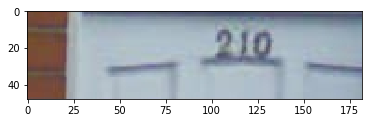

In [18]:
#padded_labels[padded_labels == 10] = 0
def remove_10s(labels):
    for label in labels:
        for i, digit in enumerate(label):
            if digit > 9:
                label[i] = 0.
                
    return labels



for i, label in enumerate(test_labels):
    if 10. in label:
        print(i, label)


        
#,1, 11, 18, 25, 34, 45
print(test_labels[1])
test_set = [test_features[1]]
        
for img in test_set:
    fig,ax  = plt.subplots(1)
    ax.imshow(img)

In [19]:
%matplotlib inline
plt.figure(figsize=(14, 7))

plt.plot(model.history.history['val_dense_9_acc'], label='First digit')
plt.plot(model.history.history['val_dense_10_acc'], label='Second digit')
plt.plot(model.history.history['val_dense_11_acc'], label='Third digit')
plt.plot(model.history.history['val_dense_12_acc'], label='Fourth digit')
plt.plot(model.history.history['val_dense_13_acc'], label='Fifth digit')
plt.plot(model.history.history['val_dense_14_acc'], label='Sixth digit')

plt.legend()
plt.title('Accuracy')
plt.show()

KeyError: 'val_dense_9_acc'

In [ ]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(features[0].reshape(1,32,32,3))

In [ ]:
plt.imshow(features[0]);

In [ ]:
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index])
            activation_index += 1

In [ ]:
display_activation(activations, 8, 8, 1)